In [19]:
from qiskit import *
from qiskit.circuit import Parameter
from itertools import combinations

Following implementataion of https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.021050 and https://arxiv.org/pdf/1804.03023.pdf for the calculation of $A$ and $C$

I am using single qubit variational gates as I have not yet figures out how it works for 2 qubit gates. Some details are there in the SM but I have to look closer at those

In [723]:
def get_circuit(n,lm=None):
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)

    circ.h(basis)
    circ.barrier()
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi))]
    cnt=0
    for j,i in enumerate(combi):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i[1]])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i[1]])
        circ.cry(theta[cnt],basis[i[0]],basis[i[1]])
        cnt+=1
    circ.barrier()

    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ

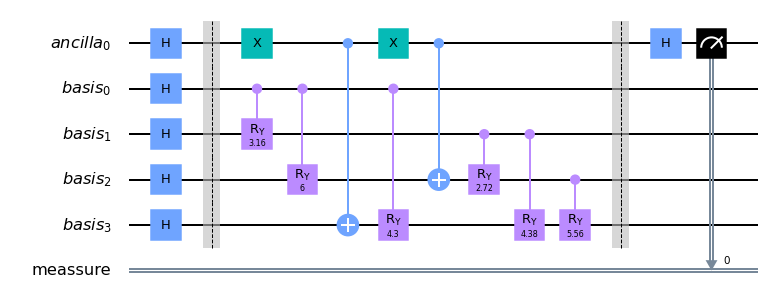

In [739]:
n=4
circ=get_circuit(n,[2,3])
values={i:np.random.uniform(0,2*np.pi) for i in circ.parameters}
circ_params=circ.assign_parameters(values)
circ_params.draw('mpl')

In [777]:
def get_lm(circ,angles):
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    circ_params_wo_meassure=circ_params.remove_final_measurements(inplace=False)
    statevector=get_final_state(circ_params_wo_meassure)
    a=np.real(statevector*statevector.conj())
    return 1-a[0::2].sum()
def get_final_state(circ_params_wo_meassure):
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circ_params_wo_meassure, simulator).result()
    statevector = result.get_statevector(circ_params_wo_meassure)
    return statevector


In [781]:
angles=np.random.uniform(0,2*np.pi,len(circ.parameters))
get_lm(circ,angles)



0.49030673860835494